# SIGNAL PROCESSING

In [11]:
import numpy as np
import mne
import pyxdf  # load file.xdf
import pandas as pd

# enable interactive plotting
%matplotlib widget  

In [12]:
# DATA PATHS

# MONTAGE FILE
MONTAGE = 'DATA/montage_perfect.csv'
#
PILOTS_TOBIAS = 'DATA/Pilots_Tobias_05.10.22/'
PILOTS_THIBAUT = 'DATA/Pilots_Thibaut_06.10.22/'
#
BASELINE_EC_THIBAUT = 'sub-Thibaut_eegBaseline_eyesclosed.xdf'
BASELINE_EC_TOBIAS = 'sub-Tobias_eegBaseline_eyesclosed.xdf'
PASSIVE_TOBIAS = 'sub-Tobias_passiveOA.xdf'
PASSIVE_THIBAUT = 'sub-Thibaut_passiveOA_2.xdf'

# load file.xdf to numpy ndarray

# xdf_file = PILOTS_THIBAUT+PASSIVE_THIBAUT
xdf_file = PILOTS_TOBIAS+PASSIVE_TOBIAS

# xdf_file = 'DATA/Pilot_Daniel_11.10.22/sub-Passive_observation_2_Daniel.xdf'
streams, header = pyxdf.load_xdf(xdf_file)


Stream 4: Calculated effective sampling rate 876.1063 Hz is different from specified rate 999.9999 Hz.


## Filter raw data  
- Create mne.io.RawArray
- Discard bad channels (manually)
- BP filter
- CAR filter

65
Creating RawArray with float64 data, n_channels=65, n_times=1238492
    Range : 0 ... 1238491 =      0.000 ...   619.245 secs
Ready.


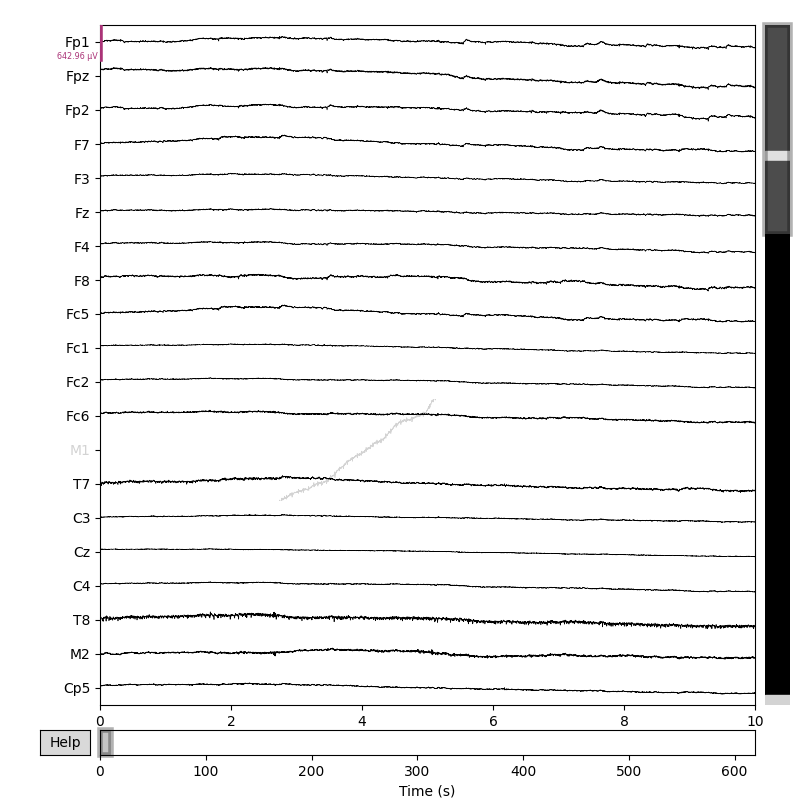

In [13]:
def get_index_of_stream_type(streams, type):
    """
    type = 'EEG', 'TargetID'
    return the index of the stream corresponding to the wanted type
    types : 'EEG', 'Markers', 'Unity.Property', 'Unity.Marker'(2 different),
    """
    if type == 'EEG': name = 'eegoSports 000650'
    elif type == 'TargetID': name = 'Unity.Marker.TargetID'
    else :
        raise NameError(
            f"given type '{type}' is not an argument. Accepted types are 'EEG' and 'TargetID'"
        )
    for i in range(len(streams)):
        if streams[i]['info']['name'][0] == name:
            return i
    raise NameError(
         f"given type '{type}' cannot be found in any of the streams"
    )

#### Create raw data
mt = pd.read_csv(MONTAGE)
ch_names = mt['ch_name'].tolist()
ch_names.append('weird_channel_65')

NB_CHANNELS = 65
EEG = get_index_of_stream_type(streams, type='EEG')

data = streams[EEG]["time_series"].copy().T  # data.shape = (nb_channels, nb_samples)
data *= 1e-6  # convert from uV to V (mne uses V)
print(len(data))
assert len(data) == NB_CHANNELS      
sfreq = float(streams[EEG]["info"]["nominal_srate"][0])
ch_types = ['eeg'] * 64 + ['misc']
info = mne.create_info(ch_names, sfreq, ch_types)
# info = mne.create_info(NB_CHANNELS, sfreq)
raw = mne.io.RawArray(data, info)


#### Handle bad channels

# discard channel [12] for 'sub-Tobias_passiveOA.xdf'
# (the channel should appear in grey on the plot)

# Example :
if xdf_file == PILOTS_TOBIAS+PASSIVE_TOBIAS :
    raw.info['bads'].extend(['M1', 'weird_channel_65'])
    
# It's possible to select bads channels directly from the graph by clicking on them once 
# but need to CLOSE the figure to update mne.Info object
# Could be interesting to implement that in the process of processing all datas

plot1 = raw.plot(scalings='auto',block=True);  # ";" to show ONLY interactive plot


In [14]:
#### BP filter on raw signal

rawBP = raw.copy().filter(l_freq=1.5, h_freq=40)
# rawBP.plot(); 


#### CAR (common average reference) filter 

rawBPCAR, ref_data = mne.set_eeg_reference(rawBP, ref_channels='average', copy=True)
# rawBPCAR.plot(); 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 4401 samples (2.200 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    9.9s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


## Segmentation of the signal with mne.Epochs
Streams TargetID+time_stamps --> mne.Annotations --> events+event_ID --> mne.Epochs

                                   |--> rawannot -----^^^-------------^^^ 

Used Annotations descriptions: ['2', '5', '8']
Not setting metadata
71 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 71 events and 12001 original time points ...
0 bad epochs dropped


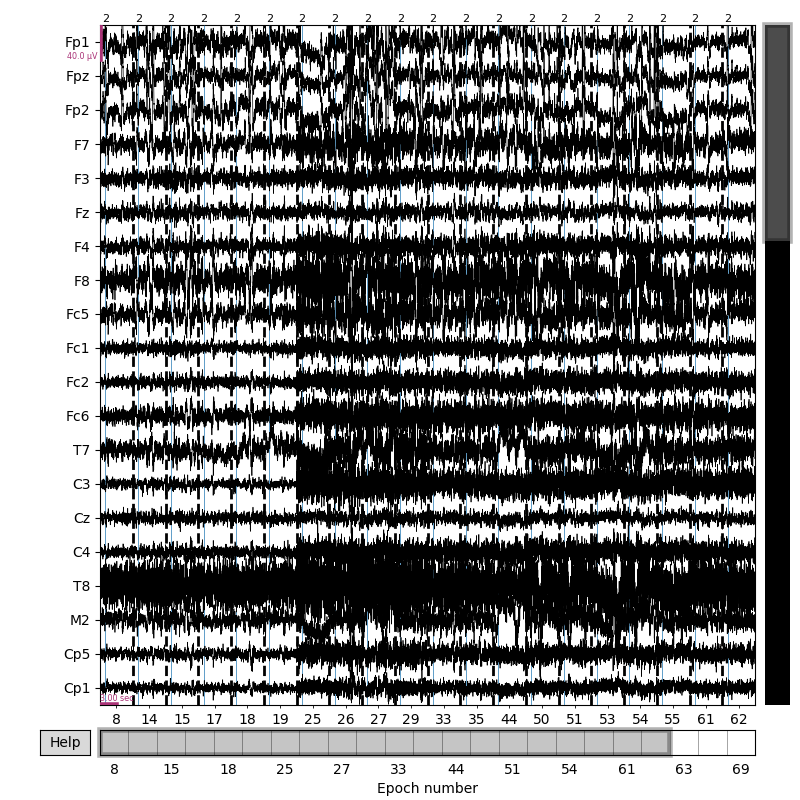

In [15]:
# Create mne.Epochs from raw preprocessed signal

TIME_OFFSET = -1  # in sec, the event window begins x seconds before the time stamp
DUR = 5 # in sec, duration of the event window in seconds
TargetID = get_index_of_stream_type(streams, 'TargetID')


#### Create mne.Annotations from TargetID stream (with time_stamps)

t_origin = streams[EEG]['time_stamps'][0]
time_stamps = streams[TargetID]['time_stamps'] - t_origin  # signal begins at 0s
target_nb = np.array(streams[TargetID]['time_series']).squeeze()  # array with target IDs
annots = mne.Annotations(onset=time_stamps, duration=0., description=target_nb)  
# 0 duration for event : easier to transform to event and add a duration when creating mne.Epochs

# add annotations to the preprocessed raw signal
rawannot = rawBPCAR.copy().set_annotations(annots)


#### Create events from annotations

events, event_ids = mne.events_from_annotations(rawannot)
# print(event_ids)
# print(events)


#### Create mne.Epochs with events and event_ID
# also define the event window 

epochs = mne.Epochs(rawBPCAR, events, event_ids, tmin=TIME_OFFSET, tmax=DUR, baseline=(TIME_OFFSET,0), reject=dict(eeg=400e-6), preload=True)  # bad channels won't appear on graph
epochs_resampled = epochs.resample(200)
# baseline : for now we do a baseline correction with the second before the event as a reference
# reject : looks for each epoch for every channel individually, if PTP is above the given threshold the respective epoch is dropped

# plot one kind of event #
epochs_resampled['2'].plot(events=events, event_id=event_ids); 

In [16]:
def extract_synchronisation_level(eeg_data, frequency_band):
    if frequency_band == 'alpha':
        fmin = 8
        fmax = 13
    elif frequency_band == 'beta':
        fmin = 13
        fmax = 30
    eeg_data_filtered = eeg_data.filter(l_freq=fmin, h_freq=fmax)
    return eeg_data_filtered


In [17]:
epochs_alpha = extract_synchronisation_level(epochs_resampled, 'alpha')
epochs_beta = extract_synchronisation_level(epochs_resampled, 'beta')

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 331 samples (1.655 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 205 samples (1.025 sec)



[Parallel(n_jobs=1)]: Done 4544 out of 4544 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4544 out of 4544 | elapsed:    1.7s finished


In [18]:
df_alpha = epochs_alpha.pick_channels(['C1', 'C2', 'C3', 'Cz', 'C4', 'C5', 'C6', 'Fc1', 'Fc2', 
                                    'Fc3', 'Fcz', 'Fc4', 'Fc5', 'Fc6', 'Cp1', 'Cp2', 'Cp3', 
                                    'Cpz', 'Cp4', 'Cp5', 'Cp6']).to_data_frame()
df_beta = epochs_beta.pick_channels(['C1', 'C2', 'C3', 'Cz', 'C4', 'C5', 'C6', 'Fc1', 'Fc2',
                                    'Fc3', 'Fcz', 'Fc4', 'Fc5', 'Fc6', 'Cp1', 'Cp2', 'Cp3', 
                                    'Cpz', 'Cp4', 'Cp5', 'Cp6']).to_data_frame()

df = pd.concat([df_alpha, df_beta], keys=['alpha', 'beta'])
df.reset_index(level = 0, inplace=True)
df.rename(columns={'level_0': 'freq_band'}, inplace=True)
df

,freq_band,time,condition,epoch,Fc5,Fc1,Fc2,Fc6,C3,Cz,...,Cpz,Fc3,Fcz,Fc4,C5,C1,C2,C6,Cp3,Cp4
0,alpha,-1.000,8,0,-0.463949,-1.140491,-0.970072,-0.497049,0.208229,-0.656207,...,0.645205,-0.792237,-1.455972,-0.930030,0.329330,-0.704401,-0.203470,0.813683,1.437540,0.673484
1,alpha,-0.995,8,0,-0.532271,-0.873313,-0.871857,-0.666066,0.348430,-0.319973,...,0.903056,-0.683025,-1.282701,-0.899066,0.293569,-0.396232,-0.038373,0.675903,1.518713,0.628718
2,alpha,-0.990,8,0,-0.485122,-0.354976,-0.550411,-0.718706,0.436436,0.175801,...,1.030878,-0.408217,-0.777099,-0.652979,0.208465,0.080735,0.196251,0.344538,1.263833,0.445944
3,alpha,-0.985,8,0,-0.341446,0.270087,-0.104161,-0.641143,0.449308,0.677114,...,0.980201,-0.043408,-0.092955,-0.270706,0.096740,0.585176,0.410345,-0.095703,0.745109,0.167634
4,alpha,-0.980,8,0,-0.143305,0.832106,0.339294,-0.448818,0.382357,1.026505,...,0.741480,0.318417,0.574638,0.138052,-0.019018,0.966155,0.517357,-0.525786,0.099845,-0.141899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85195,beta,4.975,5,70,-0.536344,0.365631,-0.290356,-0.960207,-0.892156,0.594475,...,0.560361,0.578773,0.497714,-0.323588,0.599727,0.249814,0.454193,0.171573,-0.544144,0.137385
85196,beta,4.980,5,70,-0.720348,0.147823,-0.151539,-0.931161,-0.659458,0.418325,...,0.614314,0.180802,0.200565,-0.232968,0.366938,0.292369,0.312955,-0.253540,-0.090797,0.219060
85197,beta,4.985,5,70,-0.703674,-0.167267,-0.039866,-0.655167,-0.295540,0.127582,...,0.543069,-0.364069,-0.204428,-0.161258,-0.018694,0.231301,0.078310,-0.632846,0.389025,0.266194
85198,beta,4.990,5,70,-0.543377,-0.470324,0.032152,-0.274902,0.097900,-0.173333,...,0.391458,-0.873392,-0.579908,-0.107246,-0.437118,0.108336,-0.164209,-0.874165,0.767418,0.280824


In [24]:
def calculate_power(df):
    """
    Calculate the power of each channel in a dataframe
    :param df: dataframe with EEG data
    :return: a dataframe with the power of each channel
    """
    df_power = df.copy()
    for channel in df_power.columns[4:]:
        df_power[channel] = df_power[channel].apply(lambda x: x ** 2)
    return df_power

# def calculate_power(df):
#     """
#     Calculate the power of each channel in a dataframe
#     :param df: dataframe with EEG data
#     :return: a dataframe with the power of each channel
#     """
#     df_power = pd.DataFrame()
#     for element in df.columns[:3]:
#         df_power[element] = df[element]
#     for channel in df.columns[3:]:
#         power = df[channel].apply(lambda x: x ** 2)
#         df_power[channel] = power
#     return df_power

df_power = calculate_power(df)
df_power

,freq_band,time,condition,epoch,Fc5,Fc1,Fc2,Fc6,C3,Cz,...,Cpz,Fc3,Fcz,Fc4,C5,C1,C2,C6,Cp3,Cp4
0,alpha,-1.000,8,0,0.215249,1.300720,0.941040,0.247058,0.043359,0.430608,...,0.416289,0.627640,2.119853,0.864956,0.108458,0.496181,0.041400,0.662080,2.066522,0.453581
1,alpha,-0.995,8,0,0.283312,0.762675,0.760134,0.443644,0.121403,0.102382,...,0.815510,0.466523,1.645321,0.808319,0.086183,0.157000,0.001472,0.456845,2.306490,0.395286
2,alpha,-0.990,8,0,0.235343,0.126008,0.302953,0.516538,0.190476,0.030906,...,1.062709,0.166641,0.603882,0.426382,0.043458,0.006518,0.038515,0.118706,1.597273,0.198866
3,alpha,-0.985,8,0,0.116586,0.072947,0.010849,0.411064,0.201878,0.458484,...,0.960794,0.001884,0.008641,0.073282,0.009359,0.342431,0.168383,0.009159,0.555187,0.028101
4,alpha,-0.980,8,0,0.020536,0.692400,0.115121,0.201438,0.146197,1.053712,...,0.549792,0.101389,0.330209,0.019058,0.000362,0.933455,0.267659,0.276451,0.009969,0.020135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85195,beta,4.975,5,70,0.287664,0.133686,0.084307,0.921998,0.795943,0.353400,...,0.314004,0.334978,0.247719,0.104709,0.359673,0.062407,0.206291,0.029437,0.296093,0.018875
85196,beta,4.980,5,70,0.518901,0.021852,0.022964,0.867060,0.434885,0.174996,...,0.377381,0.032689,0.040226,0.054274,0.134644,0.085480,0.097941,0.064282,0.008244,0.047987
85197,beta,4.985,5,70,0.495156,0.027978,0.001589,0.429243,0.087344,0.016277,...,0.294924,0.132546,0.041791,0.026004,0.000349,0.053500,0.006132,0.400494,0.151340,0.070859
85198,beta,4.990,5,70,0.295259,0.221205,0.001034,0.075571,0.009584,0.030044,...,0.153240,0.762813,0.336294,0.011502,0.191072,0.011737,0.026965,0.764164,0.588930,0.078862


In [41]:
# def calculate_mean_power_across_condition(df):
#     """
#     Calculate the mean power of each channel across conditions
#     :param df: dataframe with EEG data
#     :return: a dataframe with the mean power of each channel across conditions
#     """
#     df_mean_power = pd.DataFrame()
#     for channel in df.columns[5:]:
#         mean_power = df.groupby(['freq_band', 'condition'])[channel].mean()
#         df_mean_power[channel] = mean_power
#     return df_mean_power

def calculate_mean_power_over_all_trials(df):
    """
    Calculate the mean power of each channel over all trials for each condition
    :param df: dataframe with EEG data
    :return: a dataframe with the mean power of each channel across conditions and trials
    """
    df_mean_power = pd.DataFrame()
    for channel in df.columns[4:]:
        mean_power = df.groupby(['freq_band', 'condition', 'time'])[channel].mean()
        df_mean_power[channel] = mean_power
    df_mean_power.reset_index(inplace=True)
    return df_mean_power

df_mean_power = calculate_mean_power_over_all_trials(df_power)
df_mean_power

,freq_band,condition,time,Fc5,Fc1,Fc2,Fc6,C3,Cz,C4,...,Cpz,Fc3,Fcz,Fc4,C5,C1,C2,C6,Cp3,Cp4
0,alpha,2,-1.000,1.145664,1.205929,0.827900,2.008352,1.979990,0.601922,0.799146,...,0.627717,2.045824,0.817520,0.857987,2.605653,1.190745,0.376127,0.799407,1.129929,0.788797
1,alpha,2,-0.995,1.155947,0.975965,0.891802,1.098561,1.557929,0.669958,0.873283,...,0.582453,1.588134,0.822130,0.933268,2.984197,1.037133,0.488619,0.702403,0.827681,0.647649
2,alpha,2,-0.990,1.356369,0.557437,0.817111,0.381493,0.865706,0.609028,0.827357,...,0.513497,0.954004,0.721762,0.849229,3.210856,0.608321,0.602151,0.482401,0.446670,0.667075
3,alpha,2,-0.985,1.764375,0.411951,0.746647,0.755275,0.709123,0.524715,0.778022,...,0.568196,0.863348,0.698556,0.751698,3.391796,0.353573,0.672025,0.416271,0.445571,1.004630
4,alpha,2,-0.980,2.034985,0.666451,0.731697,1.799105,1.238261,0.485427,0.755636,...,0.722603,1.384995,0.774068,0.712388,3.336854,0.507425,0.625798,0.549713,0.843013,1.379530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,beta,8,4.975,1.287005,0.971937,1.348375,1.160452,1.242018,0.308868,1.481880,...,0.377058,3.360130,0.666844,1.468685,3.552265,0.487557,0.510503,2.059097,0.737411,1.040059
7196,beta,8,4.980,0.729137,0.549381,1.131976,1.120724,0.777704,0.235848,1.232804,...,0.194604,1.770920,0.416342,1.261021,2.127607,0.373511,0.358488,1.431724,0.572227,0.710989
7197,beta,8,4.985,0.367132,0.535366,0.732861,0.876594,0.674016,0.373166,0.766437,...,0.199897,0.999939,0.410667,0.811889,0.911773,0.555130,0.339450,0.602655,0.522980,0.400046
7198,beta,8,4.990,0.481044,0.929278,0.523646,0.652928,1.059963,0.605955,0.513919,...,0.390996,1.739726,0.628668,0.537774,1.179281,0.887912,0.476168,0.286731,0.646897,0.351254


In [42]:
def extract_time_windows(df, fs, win_len, step):
    """
    Extract time windows from a dataframe with EEG data
    :param df: dataframe with EEG data
    :param fs: sampling frequency
    :param win_len: length of the time windows in seconds
    :param step: step between two consecutive windows in seconds
    :return: a list of dataframes, each dataframe is a time window
    """
    win_size = int(win_len * fs)
    # print('window size : ' +str(win_size) + ' samples')
    step_size = int(step * fs)
    # print('step size : ' +str(step_size) + ' samples')
    df_win = pd.DataFrame()
    idx = 200
    win_num = 0

    while idx < df.shape[0] - win_size:
        win = df.iloc[idx:idx + win_size, :]
        win.insert(loc=3, column='window', value=win_num)
        # win['window'] = pd.Series([win_num for x in range(len(win))], index=win.index)
        df_win = pd.concat([df_win, win], ignore_index=True)
        idx += step_size
        win_num += 1

    return df_win
    

# df_windows = pd.DataFrame()
# for epoch in df['epoch'].unique():
#     trial = df[df['epoch'] == epoch]   
#     trial_windows = extract_time_windows(df=trial, fs=200, win_len=1.000, step=0.200)
#     df_windows = pd.concat([df_windows, trial_windows], ignore_index=True)    

df_windows = pd.DataFrame()
for freq_band in df_mean_power['freq_band'].unique():
    for condition in df_mean_power['condition'].unique():
        trial = df_mean_power[(df_mean_power['freq_band'] == freq_band) & (df_mean_power['condition'] == condition)]
        trial_windows = extract_time_windows(df=trial, fs=200, win_len=1.000, step=0.200)
        
        df_windows = pd.concat([df_windows, trial_windows], ignore_index=True)


In [43]:
df_windows

,freq_band,condition,time,window,Fc5,Fc1,Fc2,Fc6,C3,Cz,...,Cpz,Fc3,Fcz,Fc4,C5,C1,C2,C6,Cp3,Cp4
0,alpha,2,0.000,0,1.537059,1.841327,2.117384,2.229118,1.461403,0.641386,...,0.511283,4.633827,1.352981,2.317839,4.312383,1.182611,0.691035,1.134293,0.669341,1.648813
1,alpha,2,0.005,0,1.602620,1.650143,1.833755,2.133525,1.064539,0.578701,...,0.559124,3.986195,1.114110,2.062108,4.066844,1.009659,0.651623,1.626140,0.549041,1.888466
2,alpha,2,0.010,0,1.845591,1.355876,1.370515,1.840763,0.905151,0.608080,...,0.543764,2.934557,1.180694,1.539968,3.612759,0.813984,0.680314,1.962235,0.514003,2.067714
3,alpha,2,0.015,0,2.087930,1.113199,1.030521,1.544230,1.079383,0.694246,...,0.462367,2.124189,1.477398,1.099615,3.241530,0.695192,0.756055,1.921724,0.582111,2.056213
4,alpha,2,0.020,0,2.178076,1.040928,1.040757,1.412319,1.468970,0.771295,...,0.359412,2.055320,1.782702,1.043528,3.220035,0.715976,0.828331,1.518683,0.719416,1.855893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,beta,8,4.775,19,2.458423,1.650936,1.423532,1.713058,1.678107,0.694948,...,0.651756,2.774786,1.233233,1.645097,2.614606,0.897165,0.789557,1.954767,1.514714,1.598211
23996,beta,8,4.780,19,1.908074,1.467176,1.258318,1.426056,1.568638,0.577662,...,0.487139,2.385190,1.133376,1.440976,2.229794,0.724039,0.547413,1.787491,1.195954,1.227216
23997,beta,8,4.785,19,1.277455,1.258464,1.224088,1.361289,1.524776,0.568096,...,0.429865,2.352749,1.028969,1.385670,1.751347,0.710844,0.471411,1.396957,0.833013,0.906327
23998,beta,8,4.790,19,0.945815,1.166018,1.361402,1.561445,1.588960,0.687304,...,0.506334,2.673325,0.998287,1.527420,1.500686,0.879890,0.615252,0.996290,0.693608,0.819508


In [ ]:
df_windows_right = df_windows[df_windows['condition'] == '8']

In [ ]:
# STOP RUN ALL THERE
raise SystemExit("Stop right there!")

## TOPOPLOT

In [ ]:
#### Modify montage file so it is actually readable : 

# csv (with commas and not semicolons, had to change in windows advanced regional settings)
# add header bcs first row is discarded by mne
# ch_name column first
# exchange x and y columns
# ch_names with only first letter in uppercase
# final format : Ch_name,X,Y,Z

# import pandas as pd

# mt=pd.read_csv('DATA/montage.csv')
# mt['ch_name'] = mt['ch_name'].str.lower().str.title()
# mt=mt.reindex(columns=['ch_name', 'y', 'x', 'z'])
# mt=mt.rename(columns={'y':'x', 'x':'y'})
# mt.to_csv('DATA/montage_perfect.csv', index=False)


#### Montage

montage = mne.channels.read_custom_montage(MONTAGE) 
# montage.plot(sphere='eeglab');  # 'eeglab' argument to position electrodes automatically :D (only works with this specific file format)


#### Evoked data

evoked = epochs['5'].average()

print(evoked.info)
# set_montage in mne.Info
evoked.info.set_montage(montage)


#### Topoplot

times = np.arange(0.1, 5, 0.8)
evoked.plot_topomap(times, sphere='eeglab'); 

In [ ]:
print(evoked.info)

In [ ]:
%matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import pandas as pd
import seaborn as sns
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test

In [ ]:
tmin, tmax = TIME_OFFSET, DUR
freqs = np.arange(1.5, 40)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (TIME_OFFSET, 0)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test

In [ ]:
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=2)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")


In [ ]:
for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(1, 4, figsize=(12, 4),
                             gridspec_kw={"width_ratios": [10, 10, 10, 1]})
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot([ch], cmap="RdBu", cnorm=cnorm, axes=ax,
                              colorbar=False, show=False, mask=mask,
                              mask_style="mask")

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()